In [ ]:
pip install "tensorflow<2.11"

In [ ]:
pip install keras-tuner

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
from ast import literal_eval

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Conv2D, BatchNormalization, Reshape, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperParameters, RandomSearch, BayesianOptimization, GridSearch

### Data Processing

In [4]:
# Read the CSV file containing SVI parameters
# Use literal_eval to convert the 'moneyness' column from string representation to a list

param_data = pd.read_csv("../data/svi_param_dataset.csv", converters={'moneyness': literal_eval})
param_data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
param_data

,timestamp,Time_To_Maturity,a,b,rho,m,sigma,moneyness
0,2024-08-10 11:04:14,0.005479,-0.110285,6.044639,-0.282334,-0.020460,0.038765,"[-0.17811509621369015, -0.15869701035658862, -..."
1,2024-08-10 11:04:14,0.008219,-0.763708,6.859500,-0.219764,-0.029368,0.134726,"[-0.13960759904564377, -0.12091546603349118, -..."
2,2024-08-10 11:04:14,0.010959,-32.118497,33.309849,-0.244934,-0.243195,1.000000,"[-0.12159774217227369, -0.10324860350407722, -..."
3,2024-08-10 11:04:14,0.019178,-2.499705,6.115576,0.017514,0.040952,0.448595,"[-0.42263469683531946, -0.3738445326658876, -0..."
4,2024-08-10 11:04:14,0.038356,-2.040586,3.777837,-0.031391,0.022585,0.607811,"[-0.42414308361269254, -0.3753529194432604, -0..."
...,...,...,...,...,...,...,...,...
2827,2024-08-10 22:00:04,0.210959,-0.806502,1.191507,-0.350800,-0.419225,1.000000,"[-0.9143085221939722, -0.7319869654000176, -0...."
2828,2024-08-10 22:00:04,0.249315,-0.520728,0.858675,-0.046216,-0.052637,1.000000,"[-0.44867148173590404, -0.33088844607952067, -..."
2829,2024-08-10 22:00:04,0.383562,-0.403187,0.758455,-0.109753,-0.136756,1.000000,"[-1.8509392831061022, -1.4454741749979378, -1...."
2830,2024-08-10 22:00:04,0.632877,0.018290,0.435681,0.453109,0.683348,1.000000,"[-1.1886491952348825, -0.7831840871267183, -0...."


In [5]:
param_data.dtypes

timestamp            object
Time_To_Maturity    float64
a                   float64
b                   float64
rho                 float64
m                   float64
sigma               float64
moneyness            object
dtype: object

Sets timestamp and time to maturity as the indexes of the dataset

In [6]:
param_data.set_index(['timestamp', 'Time_To_Maturity'], inplace=True)
param_data

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 11:04:14 0.005479          -0.110285   6.044639 -0.282334   
                    0.008219          -0.763708   6.859500 -0.219764   
                    0.010959         -32.118497  33.309849 -0.244934   
                    0.019178          -2.499705   6.115576  0.017514   
                    0.038356          -2.040586   3.777837 -0.031391   
...                                         ...        ...       ...   
2024-08-10 22:00:04 0.210959          -0.806502   1.191507 -0.350800   
                    0.249315          -0.520728   0.858675 -0.046216   
                    0.383562          -0.403187   0.758455 -0.109753   
                    0.632877           0.018290   0.435681  0.453109   
                    0.882192           0.193321   0.227780  0.217013   

                                             m     sigma  \
timestamp           Time_To_Maturity                       
2024-08-10 11:04:14 0.005479         -0.020460  0.038765   
                    0.008219         -0.029368  0.134726   
                    0.010959         -0.243195  1.000000   
                    0.019178          0.040952  0.448595   
                    0.038356          0.022585  0.607811   
...                                        ...       ...   
2024-08-10 22:00:04 0.210959         -0.419225  1.000000   
                    0.249315         -0.052637  1.000000   
                    0.383562         -0.136756  1.000000   
                    0.632877          0.683348  1.000000   
                    0.882192          0.298585  1.000000   

                                                                              moneyness  
timestamp           Time_To_Maturity                                                     
2024-08-10 11:04:14 0.005479          [-0.17811509621369015, -0.15869701035658862, -...  
                    0.008219          [-0.13960759904564377, -0.12091546603349118, -...  
                    0.010959          [-0.12159774217227369, -0.10324860350407722, -...  
                    0.019178          [-0.42263469683531946, -0.3738445326658876, -0...  
                    0.038356          [-0.42414308361269254, -0.3753529194432604, -0...  
...                                                                                 ...  
2024-08-10 22:00:04 0.210959          [-0.9143085221939722, -0.7319869654000176, -0....  
                    0.249315          [-0.44867148173590404, -0.33088844607952067, -...  
                    0.383562          [-1.8509392831061022, -1.4454741749979378, -1....  
                    0.632877          [-1.1886491952348825, -0.7831840871267183, -0....  
                    0.882192          [-1.2171762045433445, -0.8117110964351802, -0....  

[2832 rows x 6 columns]

In [7]:
param_data_moneyness = param_data

In [8]:
param_data = param_data.drop("moneyness", axis=1)

In [9]:
param_data

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 11:04:14 0.005479          -0.110285   6.044639 -0.282334   
                    0.008219          -0.763708   6.859500 -0.219764   
                    0.010959         -32.118497  33.309849 -0.244934   
                    0.019178          -2.499705   6.115576  0.017514   
                    0.038356          -2.040586   3.777837 -0.031391   
...                                         ...        ...       ...   
2024-08-10 22:00:04 0.210959          -0.806502   1.191507 -0.350800   
                    0.249315          -0.520728   0.858675 -0.046216   
                    0.383562          -0.403187   0.758455 -0.109753   
                    0.632877           0.018290   0.435681  0.453109   
                    0.882192           0.193321   0.227780  0.217013   

                                             m     sigma  
timestamp           Time_To_Maturity                      
2024-08-10 11:04:14 0.005479         -0.020460  0.038765  
                    0.008219         -0.029368  0.134726  
                    0.010959         -0.243195  1.000000  
                    0.019178          0.040952  0.448595  
                    0.038356          0.022585  0.607811  
...                                        ...       ...  
2024-08-10 22:00:04 0.210959         -0.419225  1.000000  
                    0.249315         -0.052637  1.000000  
                    0.383562         -0.136756  1.000000  
                    0.632877          0.683348  1.000000  
                    0.882192          0.298585  1.000000  

[2832 rows x 5 columns]

In [10]:
param_data.index.get_level_values(1).unique()

Index([0.0054794520547945, 0.0082191780821917,  0.010958904109589,
       0.0191780821917808, 0.0383561643835616, 0.0575342465753424,
       0.1342465753424657,  0.210958904109589, 0.2493150684931507,
       0.3835616438356164, 0.6328767123287671, 0.8821917808219178],
      dtype='float64', name='Time_To_Maturity')

In [11]:
len(param_data.index.get_level_values(1).unique())

12

Data Splitting

In [12]:
def create_sequences(data, seq_length):
    xs, ys, y_indexes = [], [], []
    for i in range(0,len(data)-seq_length, seq_length):
        x = data.iloc[i:(i+seq_length)].values
        y = data.iloc[i+seq_length : (i+seq_length+seq_length)].values
        y_index = data.iloc[i+seq_length : (i+seq_length+seq_length)].index

        xs.append(x)
        ys.append(y)
        y_indexes.append(y_index)

    return np.array(xs), np.array(ys), np.array(y_indexes)

seq_length = len(param_data.index.get_level_values(1).unique()) 
X, y, y_indexes = create_sequences(param_data[['a', 'b', 'rho', 'm', 'sigma']], seq_length)

In [13]:
data_split_pct = 0.7
data_split_index = int(len(X)*data_split_pct)

In [14]:
X_train, X_test = X[:data_split_index] , X[data_split_index:] 
y_train, y_test = y[:data_split_index], y[data_split_index:]

In [15]:
X_train

array([[[-1.10285254e-01,  6.04463883e+00, -2.82333942e-01,
         -2.04601504e-02,  3.87651031e-02],
        [-7.63707752e-01,  6.85950004e+00, -2.19764350e-01,
         -2.93684083e-02,  1.34726222e-01],
        [-3.21184971e+01,  3.33098491e+01, -2.44934150e-01,
         -2.43195484e-01,  1.00000000e+00],
        ...,
        [-4.20683778e-01,  7.69900592e-01, -1.11262197e-01,
         -1.50724987e-01,  1.00000000e+00],
        [-9.28438375e-03,  4.08343171e-01,  2.17193796e-01,
          3.04126372e-01,  1.00000000e+00],
        [ 1.66794586e-01,  2.44438147e-01,  6.49581252e-02,
          9.83678636e-02,  1.00000000e+00]],

       [[-1.12167284e-01,  6.06187112e+00, -2.87849787e-01,
         -2.11379087e-02,  3.96401828e-02],
        [-9.40164593e-01,  7.30513156e+00, -1.99080109e-01,
         -2.82755673e-02,  1.51100254e-01],
        [-2.26762225e+01,  2.79561258e+01, -2.40728907e-01,
         -1.99479233e-01,  8.42259534e-01],
        ...,
        [-4.17864708e-01,  7.6782777

In [16]:
X_test

array([[[ 9.64642361e-02,  4.65678118e+00, -2.84991333e-01,
         -1.08464030e-02,  1.33726732e-02],
        [-5.93066150e-02,  3.93307651e+00, -1.22246190e-01,
          8.33284434e-03,  6.17677585e-02],
        [-2.28562647e+01,  2.37991461e+01, -2.40321046e-01,
         -2.34925524e-01,  1.00000000e+00],
        ...,
        [-4.15843707e-01,  7.68390719e-01, -1.16474827e-01,
         -1.61151481e-01,  1.00000000e+00],
        [-3.23810776e-03,  4.08056169e-01,  2.53017301e-01,
          3.50156482e-01,  1.00000000e+00],
        [ 2.01394117e-01,  2.21539496e-01,  2.29387789e-01,
          2.96550940e-01,  1.00000000e+00]],

       [[ 1.01245652e-01,  4.61504522e+00, -2.81809408e-01,
         -1.01347299e-02,  1.24918305e-02],
        [-3.72429882e-02,  3.86962010e+00, -1.51606611e-01,
          5.57646665e-03,  5.70475739e-02],
        [-2.25140441e+01,  2.34454262e+01, -2.39843361e-01,
         -2.34799801e-01,  1.00000000e+00],
        ...,
        [-4.16888461e-01,  7.6898270

In [17]:
y_test_indexes= y_indexes[data_split_index:]

Scales the train and test data

In [18]:
def scale_dataset(train_data:np.ndarray, test_data:np.ndarray):
    scaled_train_data = []
    scaled_test_data = []
    scalers = []

    for i in range(5):
        scaler = MinMaxScaler()

        train_ith_feature = train_data[:, :, i]
        test_ith_feature = test_data[:, :, i]

        scaler.fit(train_ith_feature)

        scaled_train_ith_feature = scaler.transform(train_ith_feature)
        scaled_test_ith_feature = scaler.transform(test_ith_feature)

        scaled_train_data.append(scaled_train_ith_feature)
        scaled_test_data.append(scaled_test_ith_feature)
        scalers.append(scaler)

    scaled_train_data = np.stack(scaled_train_data, axis=-1).reshape(train_data.shape)
    scaled_test_data = np.stack(scaled_test_data, axis=-1).reshape(test_data.shape)

    return scaled_train_data, scaled_test_data, scalers

In [19]:
X_train_scaled, X_test_scaled, X_scalers = scale_dataset(X_train, X_test)
y_train_scaled, y_test_scaled, y_scalers = scale_dataset(y_train, y_test)

In [20]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[-2], X_train_scaled.shape[-1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[-2], X_test_scaled.shape[-1], 1)

In [21]:
X_train_scaled

array([[[[[0.0471905 ],
          [0.97513247],
          [0.89438175],
          [0.15881215],
          [0.94732452]],

         [[0.76709407],
          [0.3137058 ],
          [0.68617923],
          [0.72934926],
          [0.40348529]],

         [[0.05467478],
          [0.21545642],
          [0.98435006],
          [0.01758319],
          [1.        ]],

         ...,

         [[0.        ],
          [0.92735217],
          [0.52995159],
          [0.52901605],
          [0.        ]],

         [[0.1345174 ],
          [0.2767708 ],
          [0.21670303],
          [0.21401724],
          [1.        ]],

         [[0.50576159],
          [0.29870832],
          [0.69386468],
          [0.72369738],
          [1.        ]]]],



       [[[[0.03751361],
          [0.98890403],
          [0.81934708],
          [0.08223737],
          [0.97724205]],

         [[0.71547462],
          [0.35626076],
          [0.74153565],
          [0.73721538],
          [0.471538  ]],

     

In [22]:
y_test[:100]

array([[[ 1.01245652e-01,  4.61504522e+00, -2.81809408e-01,
         -1.01347299e-02,  1.24918305e-02],
        [-3.72429882e-02,  3.86962010e+00, -1.51606611e-01,
          5.57646665e-03,  5.70475739e-02],
        [-2.25140441e+01,  2.34454262e+01, -2.39843361e-01,
         -2.34799801e-01,  1.00000000e+00],
        ...,
        [-4.16888461e-01,  7.68982701e-01, -1.14857323e-01,
         -1.58871973e-01,  1.00000000e+00],
        [-4.72894783e-03,  4.08812457e-01,  2.46020521e-01,
          3.42414869e-01,  1.00000000e+00],
        [ 2.02081369e-01,  2.20823730e-01,  2.29322125e-01,
          2.99636864e-01,  1.00000000e+00]],

       [[ 1.15404780e-01,  4.50355775e+00, -2.76647518e-01,
         -8.36346089e-03,  8.56376134e-03],
        [-7.52818064e-02,  4.09092077e+00, -1.72357921e-01,
          2.72663846e-03,  6.37889816e-02],
        [-2.23618033e+01,  2.32863986e+01, -2.39436465e-01,
         -2.34235864e-01,  1.00000000e+00],
        ...,
        [-4.19081077e-01,  7.7095780

In [23]:
class svi_predictor:

    def __init__(self, train_x_scaled, test_x_scaled, train_y_scaled, test_y_scaled, model_name:str, learning_rate, len_expiries, len_svi_params) -> None:
        self.train_x = train_x_scaled
        self.test_x = test_x_scaled
        self.train_y = train_y_scaled
        self.test_y = test_y_scaled
        self.model_name = model_name
        self.learning_rate = learning_rate
        self.len_expiries = len_expiries
        self.len_svi_params = len_svi_params
        self.model = None
        # self.model = self._model()
        self._find_best_model()

    def _model(self, hp: HyperParameters):
        # None, 12, 5, 1
        input_shape = (None, self.len_expiries, self.len_svi_params,1)
        inputs = Input(shape=input_shape)
        
        x = ConvLSTM2D(filters=hp.Int('filters', min_value=16, max_value=64, step=16), kernel_size=(1,1), padding="same", data_format="channels_last", kernel_regularizer=l2(hp.Float('l2_regularization', min_value=0.1, max_value=0.5, step=0.1)), dropout=hp.Float('dropout', min_value=0.0,  max_value=0.05, step=0.01), return_sequences=False)(inputs)

        x = BatchNormalization()(x)

        outputs = Conv2D(filters=1, kernel_size=(1,1), kernel_regularizer=l2(hp.Float('l2_regularization', min_value=0.1, max_value=0.5, step=0.1)), padding="same", activation="linear")(x)
        outputs = Reshape((self.len_expiries, self.len_svi_params))(outputs)

        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(), loss="mae") # Compiles modeel with Adam Optimizerand MAE loss
        
        return model
    

    def _find_best_model(self):

        tuner = BayesianOptimization(
            self._model,
            objective='val_loss',
            max_trials=60, 
            num_initial_points=6,
            directory='hyperparameter_tuning',
            project_name=self.model_name
        )
        
        early_stopping = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

        tuner.search(self.train_x, self.train_y, epochs=300, validation_split=0.3, callbacks=[early_stopping, reduce_lr])
        best_hyper_parameters = tuner.get_best_hyperparameters(num_trials=1)[0]     
        print(best_hyper_parameters.values) 
        self.model = tuner.hypermodel.build(best_hyper_parameters)
    

    def train(self, epochs:int, verbose:int, validation_split:float):
        early_stopping = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)
        model_checkpoint = ModelCheckpoint("../saved_models/svi_convlstm.h5", save_best_only=True, monitor="val_loss")
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

        history = self.model.fit(x=self.train_x, y=self.train_y, epochs=epochs, verbose=verbose, callbacks=[early_stopping, reduce_lr, model_checkpoint], validation_split=validation_split)
        
        return history
    
    def test(self, scalers=y_scalers):

        predictions = self.model.predict(self.test_x)
        prev = predictions
        for i, scaler in enumerate(scalers):
            predictions_reshaped = predictions[:, :,i].reshape(-1, predictions.shape[1])
            
            predictions[:, :, i]= scaler.inverse_transform(predictions_reshaped).reshape(predictions.shape[0], predictions.shape[1])

        return predictions, prev
        

In [25]:
ssa = svi_predictor(train_x_scaled=X_train_scaled, test_x_scaled=X_test_scaled, train_y_scaled=y_train_scaled, test_y_scaled=y_test_scaled, model_name="1", learning_rate=0.0054, len_expiries=12, len_svi_params=5)

Trial 60 Complete [00h 01m 01s]
val_loss: 0.07030313462018967

Best val_loss So Far: 0.06361600756645203
Total elapsed time: 00h 55m 30s
{'filters': 16, 'l2_regularization': 0.1, 'dropout': 0.0}


----

In [26]:
ssa.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 12, 5, 1)]  0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 12, 5, 16)         1152      
                                                                 
 batch_normalization_1 (Batc  (None, 12, 5, 16)        64        
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 5, 1)          17        
                                                                 
 reshape_1 (Reshape)         (None, 12, 5)             0         
                                                                 
Total params: 1,233
Trainable params: 1,201
Non-trainable params: 32
________________________________________________________

In [27]:
history = ssa.train(epochs=300, verbose=2, validation_split=0.3)

Epoch 1/300
4/4 - 2s - loss: 0.8429 - val_loss: 0.7845 - lr: 0.0010 - 2s/epoch - 607ms/step
Epoch 2/300
4/4 - 0s - loss: 0.8127 - val_loss: 0.7592 - lr: 0.0010 - 137ms/epoch - 34ms/step
Epoch 3/300
4/4 - 0s - loss: 0.7833 - val_loss: 0.7355 - lr: 0.0010 - 151ms/epoch - 38ms/step
Epoch 4/300
4/4 - 0s - loss: 0.7546 - val_loss: 0.7134 - lr: 0.0010 - 148ms/epoch - 37ms/step
Epoch 5/300
4/4 - 0s - loss: 0.7266 - val_loss: 0.6928 - lr: 0.0010 - 128ms/epoch - 32ms/step
Epoch 6/300
4/4 - 0s - loss: 0.6991 - val_loss: 0.6736 - lr: 0.0010 - 128ms/epoch - 32ms/step
Epoch 7/300
4/4 - 0s - loss: 0.6723 - val_loss: 0.6555 - lr: 0.0010 - 128ms/epoch - 32ms/step
Epoch 8/300
4/4 - 0s - loss: 0.6460 - val_loss: 0.6381 - lr: 0.0010 - 132ms/epoch - 33ms/step
Epoch 9/300
4/4 - 0s - loss: 0.6201 - val_loss: 0.6213 - lr: 0.0010 - 132ms/epoch - 33ms/step
Epoch 10/300
4/4 - 0s - loss: 0.5944 - val_loss: 0.6050 - lr: 0.0010 - 133ms/epoch - 33ms/step
Epoch 11/300
4/4 - 0s - loss: 0.5690 - val_loss: 0.5895 - lr:

In [28]:
model_y_predictions, prev = ssa.test()

3/3 [==============================] - 1s 152ms/step


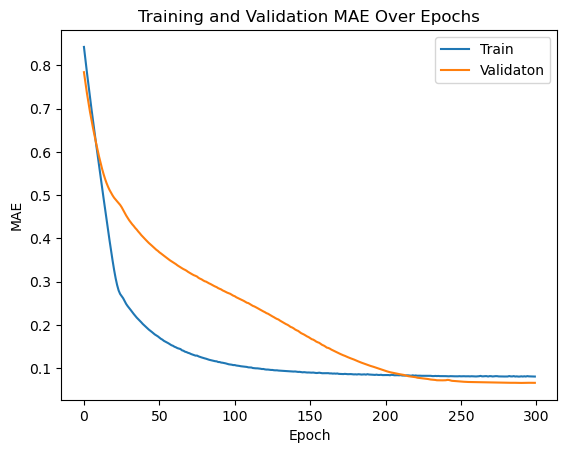

In [29]:
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validaton")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training and Validation MAE Over Epochs")
plt.legend()
plt.show()

In [30]:
coloumns_name = ["a", "b", "rho", "m", "sigma"]

In [31]:
model_y_predictions = pd.DataFrame(model_y_predictions.reshape(-1,5), columns=coloumns_name)
model_y_predictions

,a,b,rho,m,sigma
0,0.118254,4.473657,-0.285469,-0.008269,0.013427
1,-0.085757,3.958894,-0.125031,0.007314,0.062150
2,-22.893475,23.937391,-0.246248,-0.234549,0.992321
3,-1.233657,4.638950,-0.003212,0.032385,0.313606
4,-2.257370,3.873698,0.005537,0.048606,0.647414
...,...,...,...,...,...
847,-0.824319,1.191583,-0.318908,-0.373661,0.996414
848,-0.483721,0.815971,0.010198,-0.005567,1.002940
849,-0.403385,0.759157,-0.131060,-0.173546,1.002940
850,0.019228,0.429321,0.434234,0.647131,0.998344


In [32]:
y_test = pd.DataFrame(y_test.reshape(-1,5), columns=coloumns_name)
y_test

,a,b,rho,m,sigma
0,0.101246,4.615045,-0.281809,-0.010135,0.012492
1,-0.037243,3.869620,-0.151607,0.005576,0.057048
2,-22.514044,23.445426,-0.239843,-0.234800,1.000000
3,-1.225167,4.684293,-0.003908,0.031827,0.319719
4,-2.996107,4.415602,0.045797,0.080488,0.742053
...,...,...,...,...,...
847,-0.806502,1.191507,-0.350800,-0.419225,1.000000
848,-0.520728,0.858675,-0.046216,-0.052637,1.000000
849,-0.403187,0.758455,-0.109753,-0.136756,1.000000
850,0.018290,0.435681,0.453109,0.683348,1.000000


In [33]:
flat_y_test_indexes = [item for sublist in y_test_indexes for item in sublist]

In [34]:
model_y_predictions['timestamp'] = [idx[0] for idx in flat_y_test_indexes]
model_y_predictions['Time_To_Maturity'] = [idx[1] for idx in flat_y_test_indexes]
model_y_predictions.set_index(['timestamp', 'Time_To_Maturity'], inplace=True)
model_y_predictions

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 18:42:50 0.005479           0.118254   4.473657 -0.285469   
                    0.008219          -0.085757   3.958894 -0.125031   
                    0.010959         -22.893475  23.937391 -0.246248   
                    0.019178          -1.233657   4.638950 -0.003212   
                    0.038356          -2.257370   3.873698  0.005537   
...                                         ...        ...       ...   
2024-08-10 22:00:04 0.210959          -0.824319   1.191583 -0.318908   
                    0.249315          -0.483721   0.815971  0.010198   
                    0.383562          -0.403385   0.759157 -0.131060   
                    0.632877           0.019228   0.429321  0.434234   
                    0.882192           0.191798   0.227253  0.203623   

                                             m     sigma  
timestamp           Time_To_Maturity                      
2024-08-10 18:42:50 0.005479         -0.008269  0.013427  
                    0.008219          0.007314  0.062150  
                    0.010959         -0.234549  0.992321  
                    0.019178          0.032385  0.313606  
                    0.038356          0.048606  0.647414  
...                                        ...       ...  
2024-08-10 22:00:04 0.210959         -0.373661  0.996414  
                    0.249315         -0.005567  1.002940  
                    0.383562         -0.173546  1.002940  
                    0.632877          0.647131  0.998344  
                    0.882192          0.276549  0.997979  

[852 rows x 5 columns]

In [35]:
y_test['timestamp'] = [idx[0] for idx in flat_y_test_indexes]
y_test['Time_To_Maturity'] = [idx[1] for idx in flat_y_test_indexes]
y_test.set_index(['timestamp', 'Time_To_Maturity'], inplace=True)
y_test

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 18:42:50 0.005479           0.101246   4.615045 -0.281809   
                    0.008219          -0.037243   3.869620 -0.151607   
                    0.010959         -22.514044  23.445426 -0.239843   
                    0.019178          -1.225167   4.684293 -0.003908   
                    0.038356          -2.996107   4.415602  0.045797   
...                                         ...        ...       ...   
2024-08-10 22:00:04 0.210959          -0.806502   1.191507 -0.350800   
                    0.249315          -0.520728   0.858675 -0.046216   
                    0.383562          -0.403187   0.758455 -0.109753   
                    0.632877           0.018290   0.435681  0.453109   
                    0.882192           0.193321   0.227780  0.217013   

                                             m     sigma  
timestamp           Time_To_Maturity                      
2024-08-10 18:42:50 0.005479         -0.010135  0.012492  
                    0.008219          0.005576  0.057048  
                    0.010959         -0.234800  1.000000  
                    0.019178          0.031827  0.319719  
                    0.038356          0.080488  0.742053  
...                                        ...       ...  
2024-08-10 22:00:04 0.210959         -0.419225  1.000000  
                    0.249315         -0.052637  1.000000  
                    0.383562         -0.136756  1.000000  
                    0.632877          0.683348  1.000000  
                    0.882192          0.298585  1.000000  

[852 rows x 5 columns]

In [36]:
model_y_predictions = model_y_predictions.join(param_data_moneyness[['moneyness']], how='left')
model_y_predictions

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 18:42:50 0.005479           0.118254   4.473657 -0.285469   
                    0.008219          -0.085757   3.958894 -0.125031   
                    0.010959         -22.893475  23.937391 -0.246248   
                    0.019178          -1.233657   4.638950 -0.003212   
                    0.038356          -2.257370   3.873698  0.005537   
...                                         ...        ...       ...   
2024-08-10 22:00:04 0.210959          -0.824319   1.191583 -0.318908   
                    0.249315          -0.483721   0.815971  0.010198   
                    0.383562          -0.403385   0.759157 -0.131060   
                    0.632877           0.019228   0.429321  0.434234   
                    0.882192           0.191798   0.227253  0.203623   

                                             m     sigma  \
timestamp           Time_To_Maturity                       
2024-08-10 18:42:50 0.005479         -0.008269  0.013427   
                    0.008219          0.007314  0.062150   
                    0.010959         -0.234549  0.992321   
                    0.019178          0.032385  0.313606   
                    0.038356          0.048606  0.647414   
...                                        ...       ...   
2024-08-10 22:00:04 0.210959         -0.373661  0.996414   
                    0.249315         -0.005567  1.002940   
                    0.383562         -0.173546  1.002940   
                    0.632877          0.647131  0.998344   
                    0.882192          0.276549  0.997979   

                                                                              moneyness  
timestamp           Time_To_Maturity                                                     
2024-08-10 18:42:50 0.005479          [-0.17388237859060326, -0.15446429273350176, -...  
                    0.008219          [-0.13581795192587193, -0.11712581891371934, -...  
                    0.010959          [-0.1173999005411028, -0.09905076187290623, -0...  
                    0.019178          [-0.41843332280967965, -0.3696431586402476, -0...  
                    0.038356          [-0.4202985466660683, -0.37150838249663626, -0...  
...                                                                                 ...  
2024-08-10 22:00:04 0.210959          [-0.9143085221939722, -0.7319869654000176, -0....  
                    0.249315          [-0.44867148173590404, -0.33088844607952067, -...  
                    0.383562          [-1.8509392831061022, -1.4454741749979378, -1....  
                    0.632877          [-1.1886491952348825, -0.7831840871267183, -0....  
                    0.882192          [-1.2171762045433445, -0.8117110964351802, -0....  

[852 rows x 6 columns]

In [37]:
y_test = y_test.join(param_data_moneyness[['moneyness']], how='left')
y_test

a          b       rho  \
timestamp           Time_To_Maturity                                   
2024-08-10 18:42:50 0.005479           0.101246   4.615045 -0.281809   
                    0.008219          -0.037243   3.869620 -0.151607   
                    0.010959         -22.514044  23.445426 -0.239843   
                    0.019178          -1.225167   4.684293 -0.003908   
                    0.038356          -2.996107   4.415602  0.045797   
...                                         ...        ...       ...   
2024-08-10 22:00:04 0.210959          -0.806502   1.191507 -0.350800   
                    0.249315          -0.520728   0.858675 -0.046216   
                    0.383562          -0.403187   0.758455 -0.109753   
                    0.632877           0.018290   0.435681  0.453109   
                    0.882192           0.193321   0.227780  0.217013   

                                             m     sigma  \
timestamp           Time_To_Maturity                       
2024-08-10 18:42:50 0.005479         -0.010135  0.012492   
                    0.008219          0.005576  0.057048   
                    0.010959         -0.234800  1.000000   
                    0.019178          0.031827  0.319719   
                    0.038356          0.080488  0.742053   
...                                        ...       ...   
2024-08-10 22:00:04 0.210959         -0.419225  1.000000   
                    0.249315         -0.052637  1.000000   
                    0.383562         -0.136756  1.000000   
                    0.632877          0.683348  1.000000   
                    0.882192          0.298585  1.000000   

                                                                              moneyness  
timestamp           Time_To_Maturity                                                     
2024-08-10 18:42:50 0.005479          [-0.17388237859060326, -0.15446429273350176, -...  
                    0.008219          [-0.13581795192587193, -0.11712581891371934, -...  
                    0.010959          [-0.1173999005411028, -0.09905076187290623, -0...  
                    0.019178          [-0.41843332280967965, -0.3696431586402476, -0...  
                    0.038356          [-0.4202985466660683, -0.37150838249663626, -0...  
...                                                                                 ...  
2024-08-10 22:00:04 0.210959          [-0.9143085221939722, -0.7319869654000176, -0....  
                    0.249315          [-0.44867148173590404, -0.33088844607952067, -...  
                    0.383562          [-1.8509392831061022, -1.4454741749979378, -1....  
                    0.632877          [-1.1886491952348825, -0.7831840871267183, -0....  
                    0.882192          [-1.2171762045433445, -0.8117110964351802, -0....  

[852 rows x 6 columns]

In [137]:
test_time_analyse = y_test.index.get_level_values(0).unique().to_list()[28]

In [138]:
model_y_params = (model_y_predictions.xs(test_time_analyse, level="timestamp").iloc[8][0], model_y_predictions.xs(test_time_analyse, level="timestamp").iloc[8][1], model_y_predictions.xs(test_time_analyse, level="timestamp").iloc[8][2], model_y_predictions.xs(test_time_analyse, level="timestamp").iloc[8][3], model_y_predictions.xs(test_time_analyse, level="timestamp").iloc[8][4])

C:\Users\Timi Durojaiye\AppData\Local\Temp\ipykernel_38476\3083932895.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model_y_params = (model_y_predictions.xs(test_time_analyse, level="timestamp").iloc[8][0], model_y_predictions.xs(test_time_analyse, level="timestamp").iloc[8][1], model_y_predictions.xs(test_time_analyse, level="timestamp").iloc[8][2], model_y_predictions.xs(test_time_analyse, level="timestamp").iloc[8][3], model_y_predictions.xs(test_time_analyse, level="timestamp").iloc[8][4])


In [139]:
y_test_params = (y_test.xs(test_time_analyse, level="timestamp").iloc[8][0], y_test.xs(test_time_analyse, level="timestamp").iloc[8][1], y_test.xs(test_time_analyse, level="timestamp").iloc[8][2], y_test.xs(test_time_analyse, level="timestamp").iloc[8][3], y_test.xs(test_time_analyse, level="timestamp").iloc[8][4])

C:\Users\Timi Durojaiye\AppData\Local\Temp\ipykernel_38476\2859619809.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test_params = (y_test.xs(test_time_analyse, level="timestamp").iloc[8][0], y_test.xs(test_time_analyse, level="timestamp").iloc[8][1], y_test.xs(test_time_analyse, level="timestamp").iloc[8][2], y_test.xs(test_time_analyse, level="timestamp").iloc[8][3], y_test.xs(test_time_analyse, level="timestamp").iloc[8][4])


In [140]:
model_y_params

(-0.5281568, 0.862021, -0.05611234, -0.061237216, 1.00294)

In [141]:
y_test_params

(-0.56490459634155,
 0.9077586553485044,
 -0.1075574452762818,
 -0.1059765587201367,
 1.0)

In [142]:
model_y_log_money = model_y_predictions.xs(test_time_analyse, level="timestamp").iloc[8][5]

C:\Users\Timi Durojaiye\AppData\Local\Temp\ipykernel_38476\3944335536.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model_y_log_money = model_y_predictions.xs(test_time_analyse, level="timestamp").iloc[8][5]


In [143]:
y_test_log_money = y_test.xs(test_time_analyse, level="timestamp").iloc[8][5]

C:\Users\Timi Durojaiye\AppData\Local\Temp\ipykernel_38476\3401344620.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test_log_money = y_test.xs(test_time_analyse, level="timestamp").iloc[8][5]


In [144]:
%cd ..

c:\Users\Timi Durojaiye\Desktop


In [145]:
from volatility_modelling.models.svi_model import SVIModel

In [146]:
svi = SVIModel()

In [147]:
model_ivs = np.sqrt(svi.evaluate_svi(params=model_y_params, x=model_y_log_money))

In [148]:
ivs = np.sqrt(svi.evaluate_svi(params=y_test_params, x=y_test_log_money))

In [149]:
%matplotlib inline

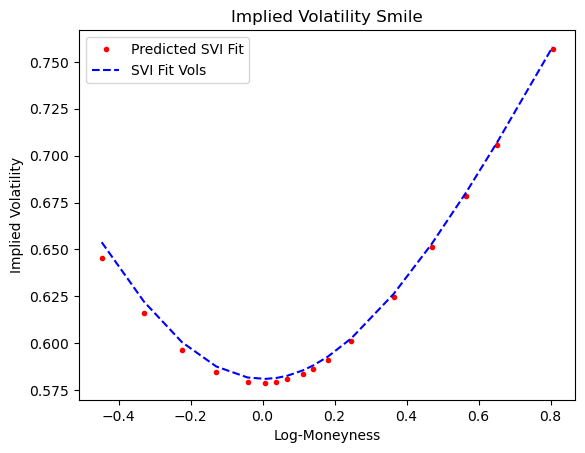

In [150]:
plt.plot(model_y_log_money, model_ivs, 'ro', label='Predicted SVI Fit', markersize=3)
plt.plot(y_test_log_money, ivs, 'b--', label='SVI Fit Vols')
plt.xlabel("Log-Moneyness")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Smile")
plt.legend()
plt.show()

In [51]:
%cd ml_models/

c:\Users\Timi Durojaiye\Desktop\Designing-optimal-options-market-making-systems-utilising-AI-for-implied-volatility-structures\ml_models


In [373]:
%cd ..

c:\Users\Timi Durojaiye\Desktop\Designing-optimal-options-market-making-systems-utilising-AI-for-implied-volatility-structures


In [374]:
from volatility_modelling.utilities.svi_surface_builder import SVISurfaceBuilder

the one before below

In [172]:
class SVISurfaceBuilders:
    def __init__(self, parametised_data):
        self.parametised_data = parametised_data
        self.maturities = self.parametised_data.index.tolist()
        self.moneyness = self.parametised_data["moneyness"]
        self.svi_model = SVIModel()

    def construct_iv_surface(self):
        """
        Constructs an implied volatility surface (IVS)

        This method constructs an IVS from the calibrated SVI parameters using the original moneyness values.

        :return:
            - iv_surface (list of np.arrays) : IVS data stored as a list of arrays, one for each maturity
            - moneyness_list (list of np.arrays) : Original moneyness values for each maturity
        """

        iv_surface = []
        moneyness_list = []

        for i, T in enumerate(self.maturities):
            params = [self.parametised_data["a"].iloc[i], self.parametised_data["b"].iloc[i], self.parametised_data["rho"].iloc[i],
                      self.parametised_data["m"].iloc[i], self.parametised_data["sigma"].iloc[i]]
            
            current_moneyness = self.moneyness.iloc[i]
            current_iv = []

            for lm in current_moneyness:
                try:
                    svi_value = self.svi_model.evaluate_svi(params, lm)
                    iv = np.sqrt(svi_value) 
                    current_iv.append(iv)
                except Exception as e:
                    print(f"Error at T={T}, lm={lm}, params={params}: {str(e)}")
                    current_iv.append(np.nan)
            
            iv_surface.append(np.array(current_iv))
            moneyness_list.append(np.array(current_moneyness))

        return iv_surface, moneyness_list

    def plot_iv_surface(self):
        iv_surface, moneyness_list = self.construct_iv_surface()

        # Flatten the data for interpolation
        X_flat = np.concatenate([np.repeat(m, len(moneyness)) for m, moneyness in zip(self.maturities, moneyness_list)])
        Y_flat = np.concatenate(moneyness_list)
        Z_flat = np.concatenate(iv_surface)

        # Create a grid for the surface plot
        X_grid, Y_grid = np.meshgrid(np.linspace(min(Y_flat), max(Y_flat), 100),
                                     np.linspace(min(X_flat), max(X_flat), 100))

        # Interpolate the irregular data onto a regular grid
        Z_grid = griddata((Y_flat, X_flat), Z_flat, (X_grid, Y_grid), method='cubic')

        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the surface
        surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap="coolwarm")

        ax.set_xlabel('Log Moneyness [ln(K/S)]')
        ax.set_ylabel('Time to Expiry (yrs)')
        ax.set_zlabel('IV')
        ax.set_title('BTC Implied Volatility Surface')
        fig.colorbar(surf, shrink=0.5, aspect=5)

        plt.show()

In [173]:
timing = model_y_predictions.index.get_level_values(0).unique().to_list()[64]
parametised_data = model_y_predictions.xs(timing, level="timestamp")

In [174]:
timing

'2024-08-10 21:43:04'

In [175]:
surface_builder = SVISurfaceBuilders(parametised_data=parametised_data)

In [167]:
%matplotlib qt 

In [176]:
%matplotlib inline

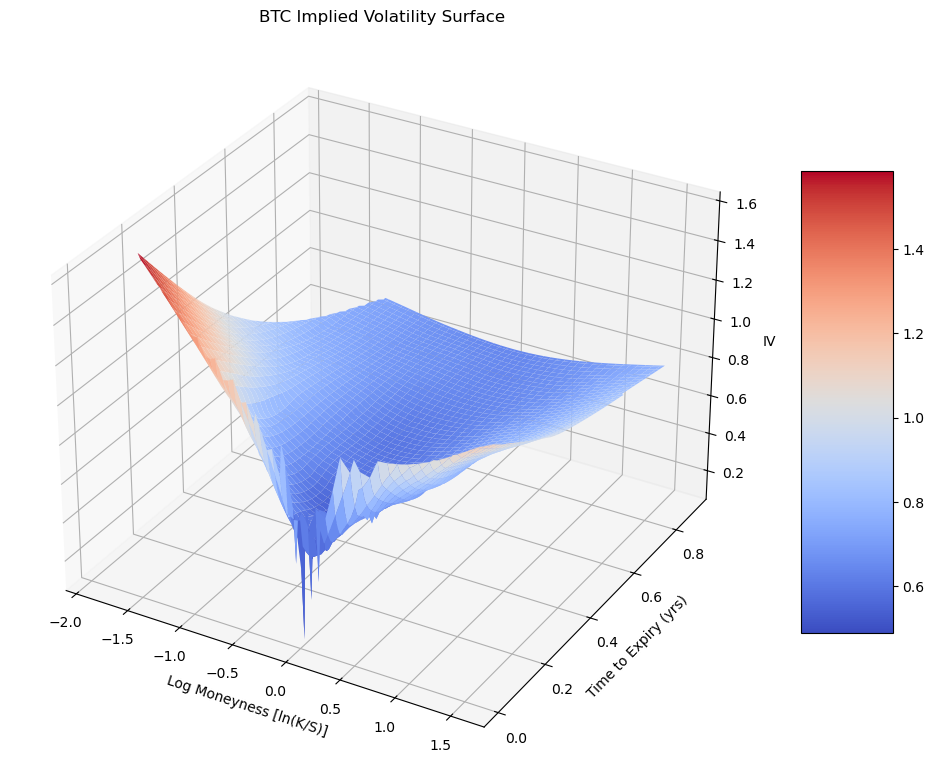

In [177]:
surface_builder.plot_iv_surface()